In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import arviz as az
import pymc3 as pm
import seaborn as sns
import theano
import theano.tensor as tt

theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"

sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('colorblind')

In [3]:
def phase(ts, phi0, f0, fdot, fddot):
    return phi0 + 2*pi*ts*(f0 + ts/2.0*(fdot + ts/3.0*fddot))

def chirp(ts, phi0, f0, fdot, fddot):
    return tt.cos(phase(ts, phi0, f0, fdot, fddot))

In [4]:
T = 100.0
N = 1000

phi0_true = 2*pi*rand()
f0_true = 1 + 0.1*randn()
fdot_true = 10/T*randn()
fddot_true = 1/(T*T)*randn()

In [5]:
phi1_true = phase(T/3, phi0_true, f0_true, fdot_true, fddot_true)
phi2_true = phase(2*T/3, phi0_true, f0_true, fdot_true, fddot_true)
phi3_true = phase(T, phi0_true, f0_true, fdot_true, fddot_true)

dphi1_true = phi1_true - phi0_true
dphi2_true = phi2_true - phi1_true
dphi3_true = phi3_true - phi2_true

In [6]:
ts = linspace(0, T, N+1)[:-1]
ys_true = chirp(ts, phi0_true, f0_true, fdot_true, fddot_true).eval()
ys_obs = ys_true + randn(N)

<ErrorbarContainer object of 3 artists>

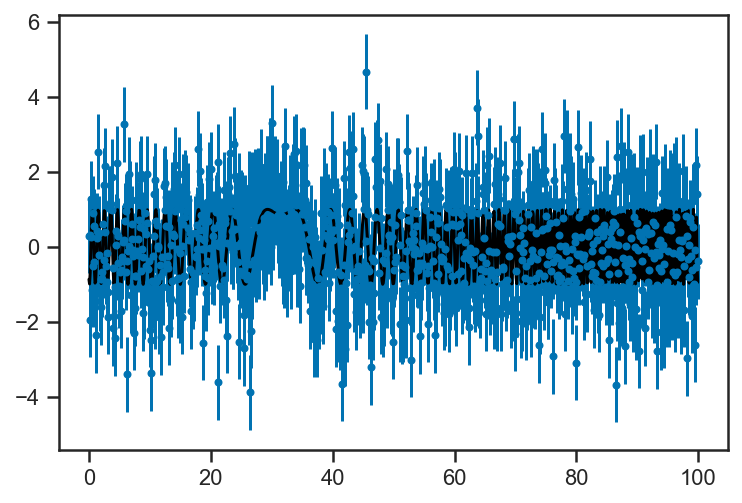

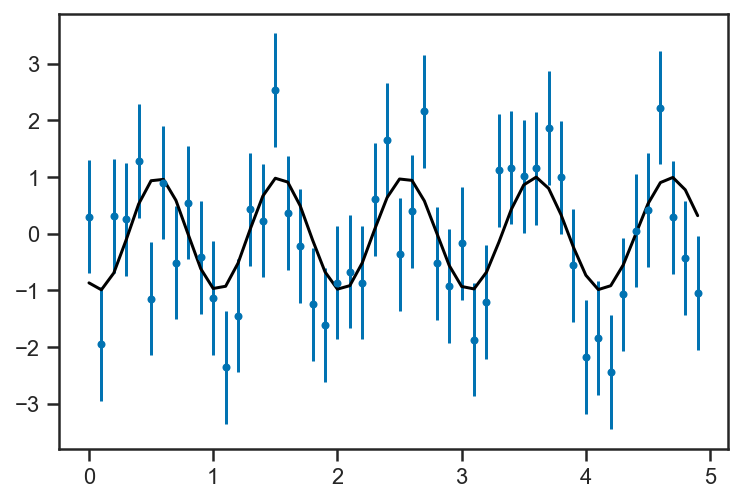

In [7]:
plot(ts, ys_true, '-k')
errorbar(ts, ys_obs, yerr=ones_like(ys_obs), fmt='.')

figure()
NN = 50
plot(ts[:NN], ys_true[:NN], '-k')
errorbar(ts[:NN], ys_obs[:NN], yerr=ones(NN), fmt='.')

In [8]:
with pm.Model() as model:
    _ = pm.Data('ys_obs', ys_obs)
    
    n_phi = pm.Normal('n_phi', mu=0, sd=1, shape=(2,), testval=randn(2))
    phi = pm.Deterministic('phi', tt.arctan2(n_phi[1], n_phi[0]))
    
    dphis = pm.Normal('dphis', mu=[dphi1_true, dphi2_true, dphi3_true], sd=2*pi/sqrt(3), shape=(3,))
    
    phi1 = phi + dphis[0]
    phi2 = phi1 + dphis[1]
    phi3 = phi2 + dphis[2]
    
    f0 = pm.Deterministic('f0', -((11*phi - 18*phi1 + 9*phi2 - 2*phi3)/(4*pi*T)))
    fdot = pm.Deterministic('fdot', (9*(2*phi - 5*phi1 + 4*phi2 - phi3))/(2*pi*T*T))
    fddot = pm.Deterministic('fddot', -((27*(phi - 3*phi1 + 3*phi2 - phi3))/(2*pi*T*T*T)))
    
    A = pm.HalfNormal('A', sigma=1)
    
    _ = pm.Normal('obs', mu=A*chirp(ts, phi, f0, fdot, fddot), sd=ones_like(ts), observed=ys_obs)

In [18]:
with model:
    trace = pm.sample(target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, dphis, n_phi]
Sampling 2 chains, 8 divergences: 100%|██████████| 2000/2000 [00:13<00:00, 146.80draws/s]
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [19]:
fit = az.from_pymc3(trace)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x137cf0650>,
      dtype=object)

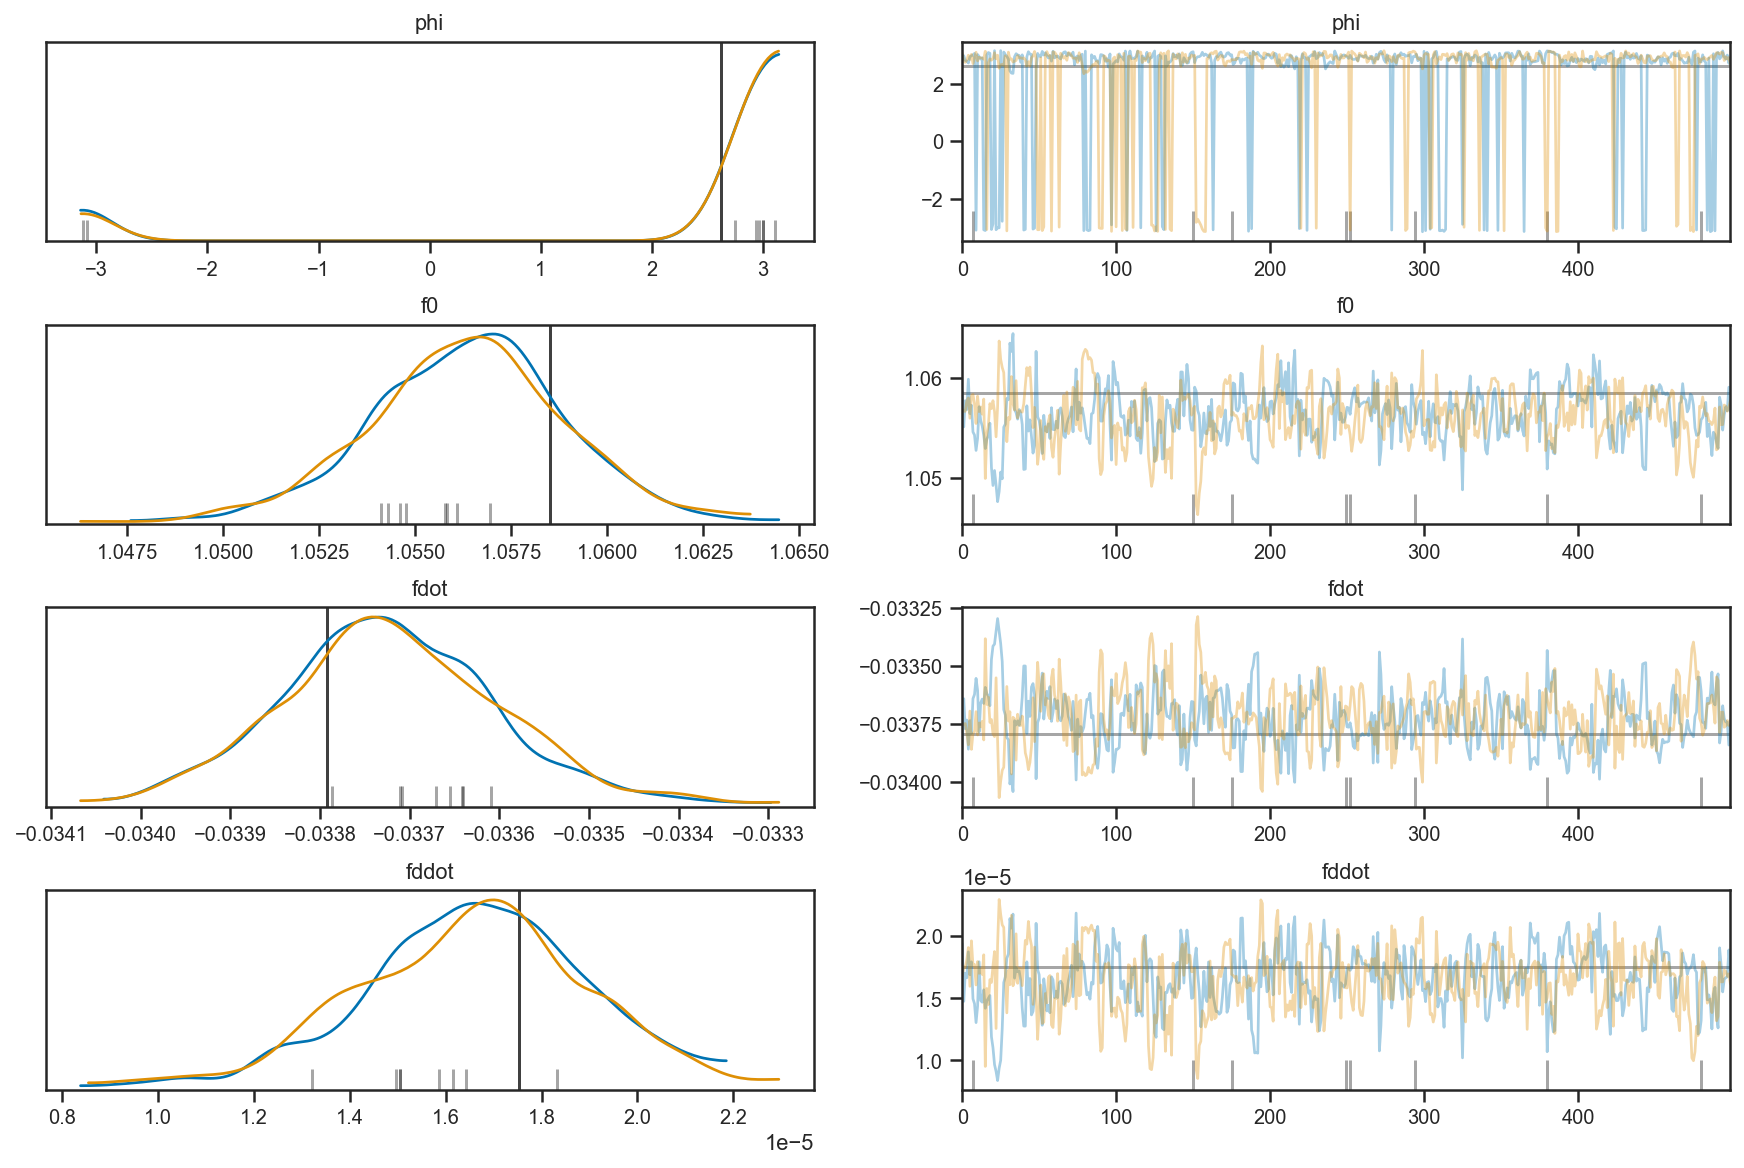

In [20]:
az.plot_trace(fit, var_names=['phi', 'f0', 'fdot', 'fddot'],
              lines=(('phi', {}, phi0_true),
                     ('f0', {}, f0_true),
                     ('fdot', {}, fdot_true),
                     ('fddot', {}, fddot_true)))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12b22ce10>,
      dtype=object)

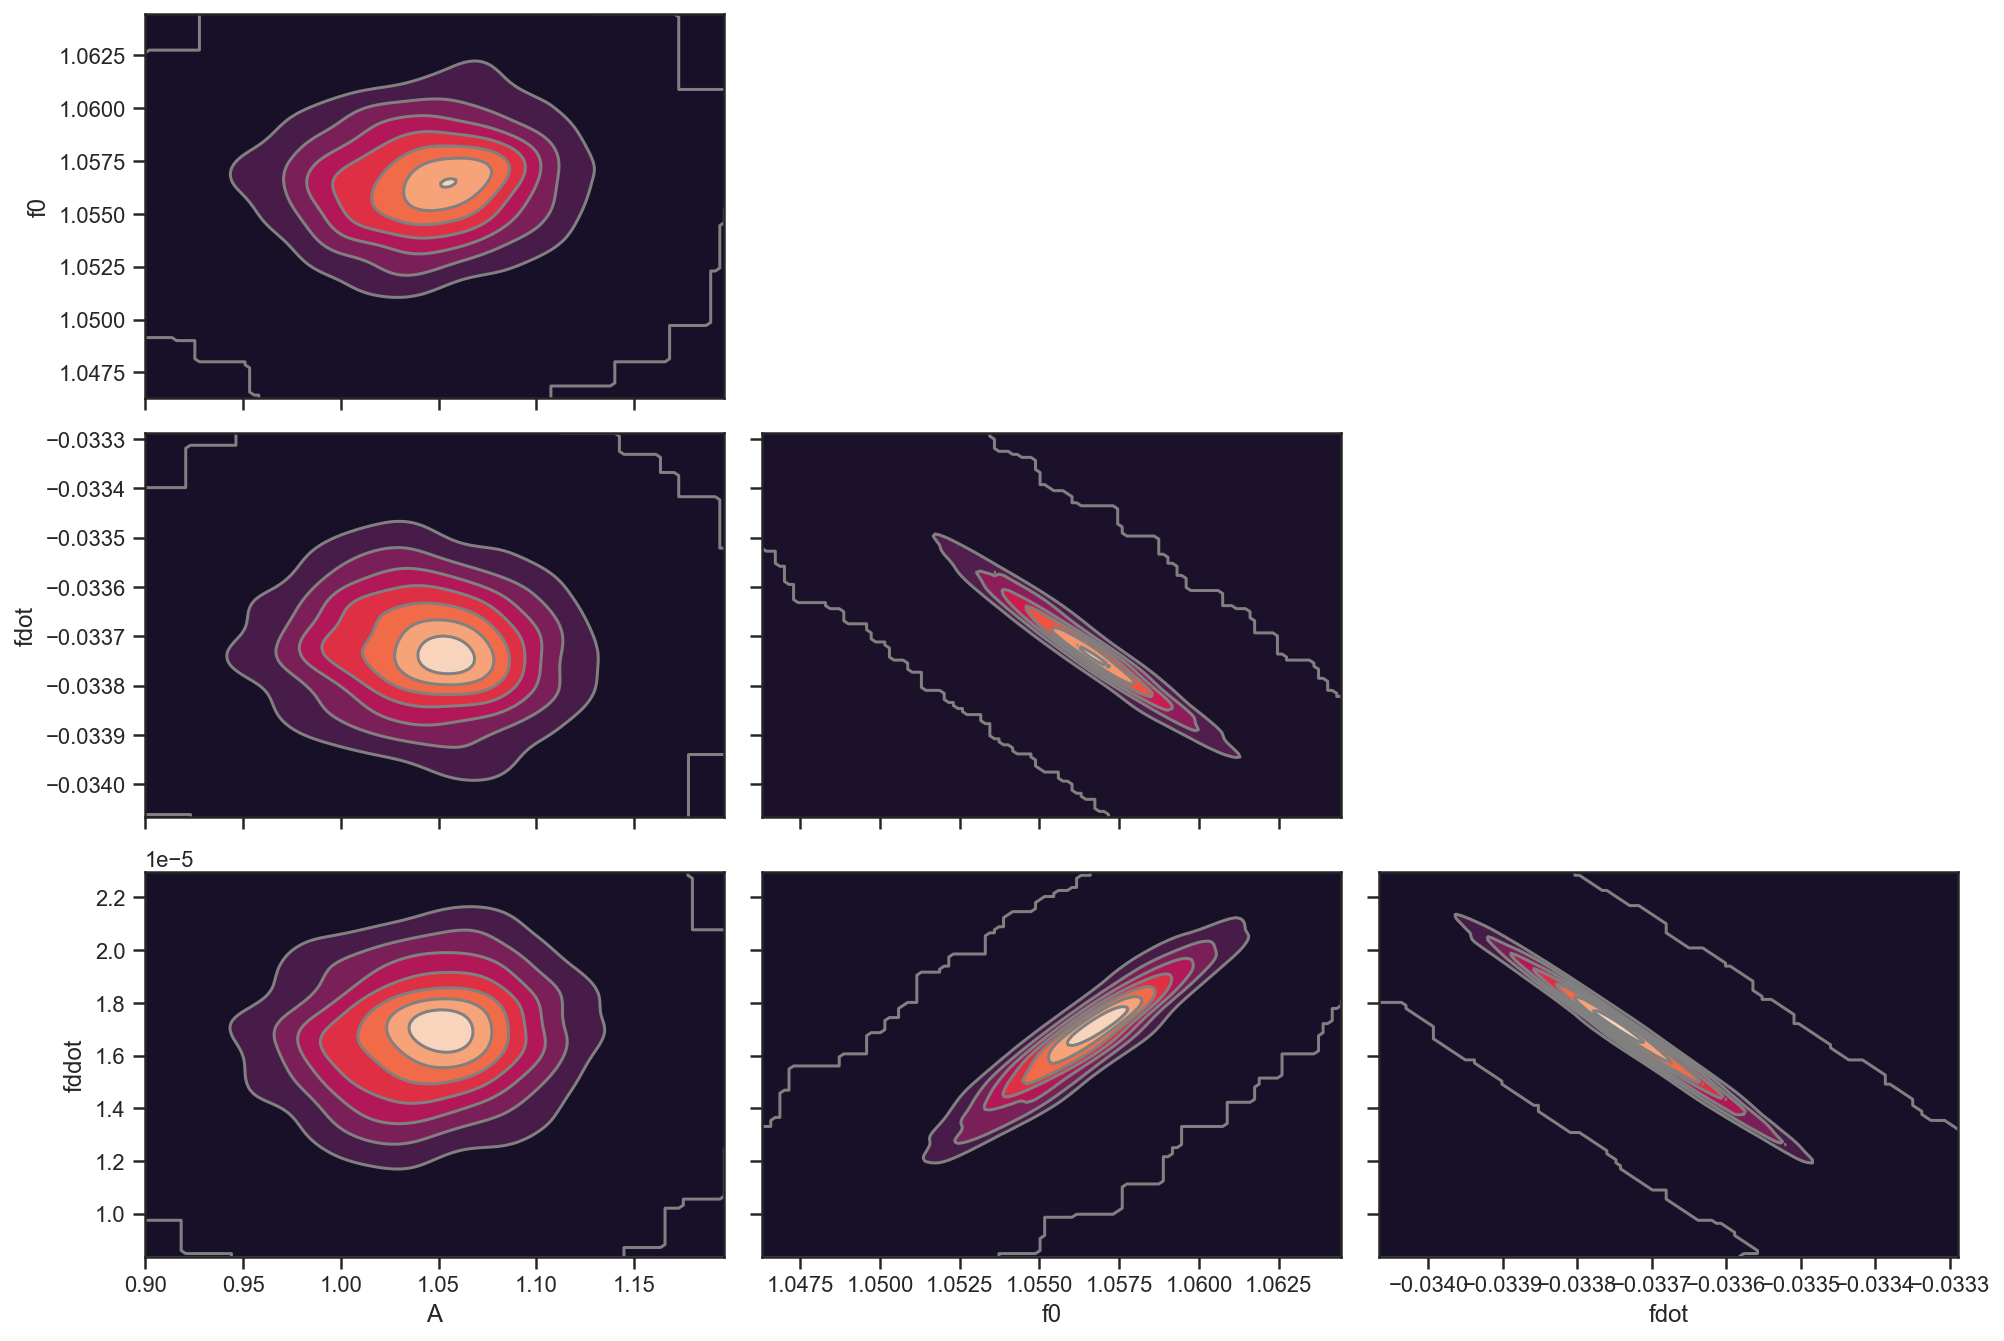

In [23]:
az.plot_pair(fit, var_names=['A', 'f0', 'fdot', 'fddot'], kind='kde')

In [24]:
with model:
    prior_trace = pm.sample_prior_predictive()

In [25]:
prior_trace

{'fdot': array([-0.03381818, -0.03430239, -0.03430041, -0.03487068, -0.03343313,
        -0.03468907, -0.03602151, -0.0331345 , -0.03157159, -0.03162744,
        -0.03166298, -0.03313189, -0.03211342, -0.03645535, -0.03158399,
        -0.03783096, -0.03792013, -0.03340393, -0.03149077, -0.03270729,
        -0.03439159, -0.03636312, -0.03251394, -0.03719971, -0.03406282,
        -0.03479284, -0.03469315, -0.03385972, -0.03226238, -0.03329686,
        -0.03426909, -0.03292583, -0.03564555, -0.03331382, -0.0343957 ,
        -0.0351053 , -0.03501361, -0.03233419, -0.03461418, -0.03019696,
        -0.03707724, -0.03597975, -0.03040442, -0.03512999, -0.0350469 ,
        -0.0325937 , -0.0360301 , -0.03195815, -0.03336238, -0.03926682,
        -0.03579196, -0.03382013, -0.03309416, -0.03524866, -0.03524186,
        -0.03511316, -0.03130985, -0.03468942, -0.0349717 , -0.03272222,
        -0.03399082, -0.03355838, -0.03376763, -0.03304732, -0.03381228,
        -0.03465173, -0.03457702, -0.031576

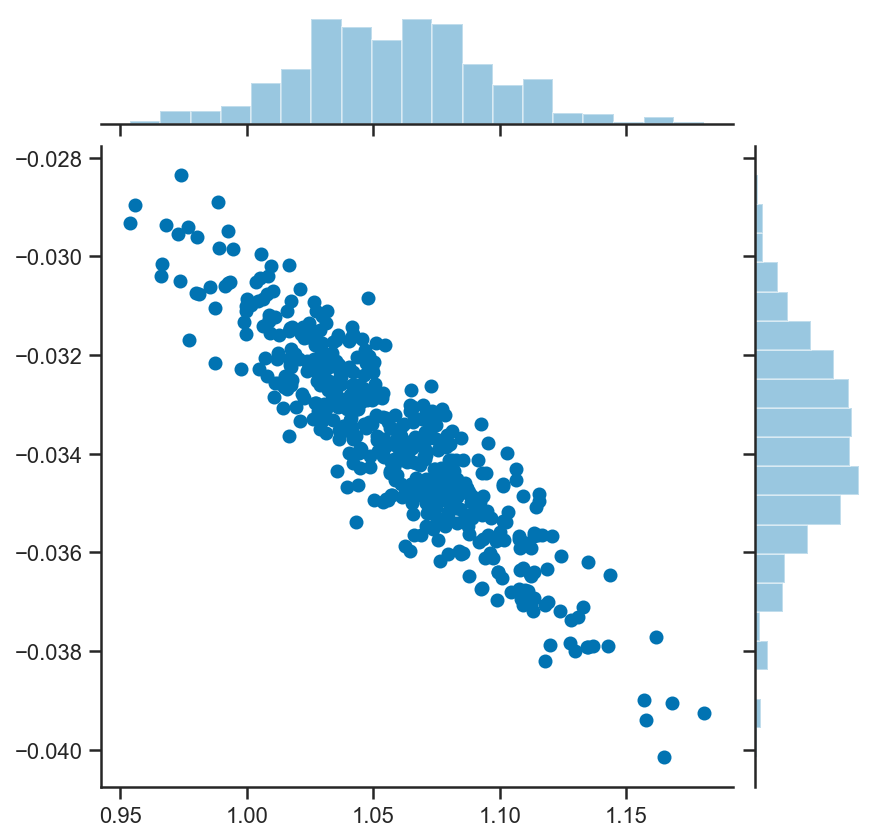

In [26]:
sns.jointplot(prior_trace['f0'], prior_trace['fdot'])

In [ ]:
pm.Normal()